In [1]:
import os, sys
sys.path.append('/global/home/users/alexandregeorges/Chapter1/')

import dask.dataframe as dd
from codebase.utils import *
from codebase.metrics import *
from codebase.params import *
import xarray as xr

In [16]:
site_code = 'GPHT'
aoi_list = [site_code]

In [4]:
data_dir = DOWNLOAD_DIR_ROOT + site_code + '/'+ '*.tif'

# Timestamps for acquired raster files
times = [i.strftime('%m-%d-%Y') for i in paths_to_datetimeindex(glob.glob(data_dir))]
time_var = xr.Variable('Observation Date', times)

In [5]:
ds = xr.open_dataset(CLASSIFIED_PREFIX+site_code+'_classified.nc')
ds

<xarray.Dataset>
Dimensions:   (y: 3828, x: 2816, time: 73)
Coordinates:
  * y         (y) float64 2.15e+06 2.15e+06 2.15e+06 ... 2.131e+06 2.131e+06
  * x         (x) float64 7.333e+05 7.333e+05 7.333e+05 ... 7.474e+05 7.474e+05
  * time      (time) object '01-15-2010' '01-23-2010' ... '02-12-2020'
Data variables:
    water     (time, y, x) bool ...
    mangrove  (time, y, x) bool ...
    mudflat   (time, y, x) bool ...
    crop      (time, y, x) bool ...
    urban     (time, y, x) bool ...
Attributes:
    description:  Classified categories for each observation time

In [5]:
%%time
uvvr_calc(times[:2], [ds['mudflat'][:2]], [ds['mangrove'][:2]], aoi_list)

CPU times: user 2.04 ms, sys: 1.03 ms, total: 3.07 ms
Wall time: 2.88 ms


Delayed('uvvr_calc-7f85f4c1-e076-4302-99a2-475b783e672d')

In [7]:
from dask.distributed import Client, progress
client = Client(addres=os.getenv('SCHED')+':8786', threads_per_worker=4, n_workers=1)
client

TypeError: unsupported operand type(s) for +: 'NoneType' and 'str'

In [2]:
import os, glob, re, datetime, math
import scipy.stats as stats
import rioxarray as rxr
from osgeo import gdal, ogr
import numpy as np


import sys
sys.path.append('/global/home/users/alexandregeorges/Chapter1/')

from codebase.params import DOWNLOAD_DIR_ROOT

In [10]:
def find_files(DOWNLOAD_DIR):
    """Return list of observation files present in download folder."""
    print('finding files to merge...')
    _files = []

    # Accessing all the harmonized images in the download directories
    for dir,_,_ in os.walk(DOWNLOAD_DIR):
        _files.extend(glob.glob(os.path.join(dir, search_criteria)))

    return _files

def find_dates(_files):
    """Finds the dates of the images in the download directories and pull the unique dates"""
    _dates = np.unique([i.strftime('%m-%d-%Y') for i in paths_to_datetimeindex(_files)])
    #tt_dates = np.unique([i.strftime('%m-%d-%Y') for i in paths_to_datetimeindex(tt_files)])
    
    print(str(len(_dates)) + ' observations were found...')
        
    return _dates

In [ ]:
site_files = DOWNLOAD_DIR_ROOT + 'TRAINING/' + code + '/' + '*.tif'
    # Getting list of available observation dates from desired sites
    site_dates = [i.strftime('%m-%d-%Y') for i in paths_to_datetimeindex(glob.glob(site_files))]
    site_dates_xr = xr.Variable('Observation Date', site_dates)
    # Putting observations in xarray
    site_obs = [rxr.open_rasterio(entry).squeeze() for entry in glob.glob(site_files)]
    site_ds = xr.concat(site_obs, dim=site_dates_xr).to_dataset(dim='Observation Date')
    # Getting Training Labels from desired sites
    labels_dir = 'datasets/Shapefiles/' + code + '_training.shp'
    site_labels = gpd.read_file('../' + labels_dir)
    # Dropping any possible NaNs from labels
    site_labels = site_labels.dropna(axis=0, how='any')

In [3]:
filelocs = DOWNLOAD_DIR_ROOT+'CCHT_test/*.tif'
shapeloc = '../'+ROOT_SHP + 'CCHT_clip' + '.shp'

input_raster = glob.glob(filelocs)[1]

<Axes: >

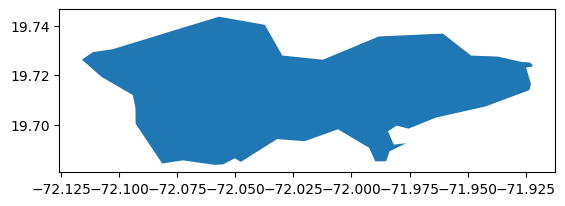

In [6]:
clip_extent = gpd.read_file(shapeloc)
clip_extent.plot()

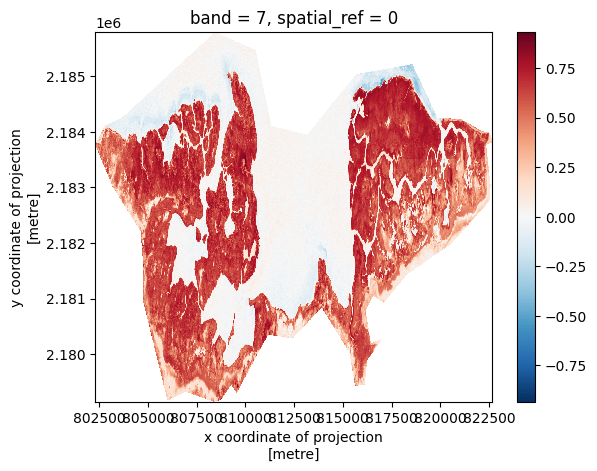

In [15]:
import geopandas as gpd
import rasterio
from rasterio import mask
from shapely.geometry import mapping

a = rxr.open_rasterio(input_raster).squeeze()
a = a.rio.clip(clip_extent.geometry.apply(mapping), clip_extent.crs)
a[-1].plot()

In [19]:
import scripts.crop

Welcome to crop tool!


: 

: 